
# Overwatch Hero Psychology: Archetype Analysis (Final Notebook)

This notebook extends the original *"We Are Who We Lock"* analysis by:
- Expanding to the full 45‑hero Overwatch roster (Season 20).
- Using **cosine similarity** to compare heroes on psychological attributes.
- Applying **PCA** to build a 2D "Hero Space".
- Applying **K‑Means clustering** to discover **four psychological archetypes**:
  - Archetype 0 — *The Skirmishers*
  - Archetype 1 — *The Tacticians*
  - Archetype 2 — *The Anchors*
  - Archetype 3 — *The Sharpshooters*
- Visualizing these archetypes with heatmaps, scatterplots, and radar charts.


In [2]:

# 0. Imports & global style

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.rcParams["figure.figsize"] = (10, 7)
sns.set_style("whitegrid")

role_colors = {"Tank": "#1f77b4", "Damage": "#d62728", "Support": "#2ca02c"}


## 1. Build hero dataset
We define the full 45‑hero Overwatch roster (Season 20) and their psychological stats.

In [3]:

# 1. Build hero dataset

columns = [
    "Hero", "Mobility", "Self_Sustain", "Mechanical_Skill",
    "HP", "Damage", "Support", "Tank"
]

heroes_data = [
    # --- TANK HEROES ---
    {"Hero": "D.Va", "Mobility": 8, "Self_Sustain": 6, "Mechanical_Skill": 5, "HP": 725, "Role": "Tank"},
    {"Hero": "Doomfist", "Mobility": 10, "Self_Sustain": 7, "Mechanical_Skill": 10, "HP": 525, "Role": "Tank"},
    {"Hero": "Hazard", "Mobility": 7, "Self_Sustain": 8, "Mechanical_Skill": 6, "HP": 650, "Role": "Tank"},
    {"Hero": "Junker Queen", "Mobility": 6, "Self_Sustain": 8, "Mechanical_Skill": 7, "HP": 525, "Role": "Tank"},
    {"Hero": "Mauga", "Mobility": 4, "Self_Sustain": 9, "Mechanical_Skill": 5, "HP": 725, "Role": "Tank"},
    {"Hero": "Orisa", "Mobility": 3, "Self_Sustain": 9, "Mechanical_Skill": 4, "HP": 625, "Role": "Tank"},
    {"Hero": "Ramattra", "Mobility": 4, "Self_Sustain": 7, "Mechanical_Skill": 6, "HP": 600, "Role": "Tank"},
    {"Hero": "Reinhardt", "Mobility": 3, "Self_Sustain": 6, "Mechanical_Skill": 4, "HP": 700, "Role": "Tank"},
    {"Hero": "Roadhog", "Mobility": 2, "Self_Sustain": 10, "Mechanical_Skill": 5, "HP": 750, "Role": "Tank"},
    {"Hero": "Sigma", "Mobility": 2, "Self_Sustain": 7, "Mechanical_Skill": 8, "HP": 625, "Role": "Tank"},
    {"Hero": "Winston", "Mobility": 8, "Self_Sustain": 5, "Mechanical_Skill": 6, "HP": 625, "Role": "Tank"},
    {"Hero": "Wrecking Ball", "Mobility": 10, "Self_Sustain": 8, "Mechanical_Skill": 10, "HP": 775, "Role": "Tank"},
    {"Hero": "Zarya", "Mobility": 2, "Self_Sustain": 6, "Mechanical_Skill": 7, "HP": 550, "Role": "Tank"},

    # --- DAMAGE HEROES ---
    {"Hero": "Ashe", "Mobility": 5, "Self_Sustain": 2, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Bastion", "Mobility": 2, "Self_Sustain": 4, "Mechanical_Skill": 4, "HP": 300, "Role": "Damage"},
    {"Hero": "Cassidy", "Mobility": 3, "Self_Sustain": 3, "Mechanical_Skill": 9, "HP": 275, "Role": "Damage"},
    {"Hero": "Echo", "Mobility": 9, "Self_Sustain": 4, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Freja", "Mobility": 6, "Self_Sustain": 3, "Mechanical_Skill": 8, "HP": 250, "Role": "Damage"},
    {"Hero": "Genji", "Mobility": 9, "Self_Sustain": 3, "Mechanical_Skill": 10, "HP": 250, "Role": "Damage"},
    {"Hero": "Hanzo", "Mobility": 5, "Self_Sustain": 2, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Junkrat", "Mobility": 7, "Self_Sustain": 2, "Mechanical_Skill": 5, "HP": 250, "Role": "Damage"},
    {"Hero": "Mei", "Mobility": 2, "Self_Sustain": 9, "Mechanical_Skill": 5, "HP": 300, "Role": "Damage"},
    {"Hero": "Pharah", "Mobility": 9, "Self_Sustain": 2, "Mechanical_Skill": 7, "HP": 250, "Role": "Damage"},
    {"Hero": "Reaper", "Mobility": 7, "Self_Sustain": 8, "Mechanical_Skill": 4, "HP": 300, "Role": "Damage"},
    {"Hero": "Sojourn", "Mobility": 8, "Self_Sustain": 2, "Mechanical_Skill": 9, "HP": 250, "Role": "Damage"},
    {"Hero": "Soldier: 76", "Mobility": 6, "Self_Sustain": 7, "Mechanical_Skill": 6, "HP": 250, "Role": "Damage"},
    {"Hero": "Sombra", "Mobility": 9, "Self_Sustain": 6, "Mechanical_Skill": 7, "HP": 250, "Role": "Damage"},
    {"Hero": "Symmetra", "Mobility": 4, "Self_Sustain": 5, "Mechanical_Skill": 6, "HP": 250, "Role": "Damage"},
    {"Hero": "Torbjörn", "Mobility": 3, "Self_Sustain": 6, "Mechanical_Skill": 5, "HP": 300, "Role": "Damage"},
    {"Hero": "Tracer", "Mobility": 10, "Self_Sustain": 4, "Mechanical_Skill": 9, "HP": 175, "Role": "Damage"},
    {"Hero": "Vendetta", "Mobility": 6, "Self_Sustain": 6, "Mechanical_Skill": 8, "HP": 250, "Role": "Damage"},
    {"Hero": "Venture", "Mobility": 8, "Self_Sustain": 6, "Mechanical_Skill": 6, "HP": 250, "Role": "Damage"},
    {"Hero": "Widowmaker", "Mobility": 4, "Self_Sustain": 1, "Mechanical_Skill": 10, "HP": 200, "Role": "Damage"},

    # --- SUPPORT HEROES ---
    {"Hero": "Ana", "Mobility": 1, "Self_Sustain": 5, "Mechanical_Skill": 9, "HP": 250, "Role": "Support"},
    {"Hero": "Baptiste", "Mobility": 6, "Self_Sustain": 7, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Brigitte", "Mobility": 4, "Self_Sustain": 7, "Mechanical_Skill": 4, "HP": 250, "Role": "Support"},
    {"Hero": "Illari", "Mobility": 5, "Self_Sustain": 6, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Juno", "Mobility": 8, "Self_Sustain": 3, "Mechanical_Skill": 6, "HP": 250, "Role": "Support"},
    {"Hero": "Kiriko", "Mobility": 8, "Self_Sustain": 7, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Lifeweaver", "Mobility": 6, "Self_Sustain": 6, "Mechanical_Skill": 4, "HP": 275, "Role": "Support"},
    {"Hero": "Lúcio", "Mobility": 9, "Self_Sustain": 6, "Mechanical_Skill": 8, "HP": 250, "Role": "Support"},
    {"Hero": "Mercy", "Mobility": 8, "Self_Sustain": 6, "Mechanical_Skill": 3, "HP": 250, "Role": "Support"},
    {"Hero": "Moira", "Mobility": 7, "Self_Sustain": 9, "Mechanical_Skill": 3, "HP": 250, "Role": "Support"},
    {"Hero": "Wuyang", "Mobility": 5, "Self_Sustain": 6, "Mechanical_Skill": 7, "HP": 250, "Role": "Support"},
    {"Hero": "Zenyatta", "Mobility": 1, "Self_Sustain": 4, "Mechanical_Skill": 9, "HP": 250, "Role": "Support"},
]

df = pd.DataFrame(heroes_data)

df["Damage"] = df["Role"].eq("Damage").astype(int)
df["Support"] = df["Role"].eq("Support").astype(int)
df["Tank"]   = df["Role"].eq("Tank").astype(int)

df = df[columns + ["Role"]]

print(df.shape)
df.head()


(45, 9)


,Hero,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank,Role
0,D.Va,8,6,5,725,0,0,1,Tank
1,Doomfist,10,7,10,525,0,0,1,Tank
2,Hazard,7,8,6,650,0,0,1,Tank
3,Junker Queen,6,8,7,525,0,0,1,Tank
4,Mauga,4,9,5,725,0,0,1,Tank


## 2. Preprocessing & basic EDA

In [4]:

features = ["Mobility", "Self_Sustain", "Mechanical_Skill", "HP"]

X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled["Hero"] = df["Hero"]
df_scaled["Role"] = df["Role"]

print(f"Loaded {len(df)} heroes.")
df.describe()


Loaded 45 heroes.


,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,5.755556,5.622222,6.777778,367.222222,0.444444,0.266667,0.288889
std,2.664203,2.279243,2.076808,186.232246,0.502519,0.447214,0.458368
min,1.000000,1.000000,3.000000,175.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,5.000000,250.000000,0.000000,0.000000,0.000000
50%,6.000000,6.000000,7.000000,250.000000,0.000000,0.000000,0.000000
75%,8.000000,7.000000,9.000000,525.000000,1.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,775.000000,1.000000,1.000000,1.000000


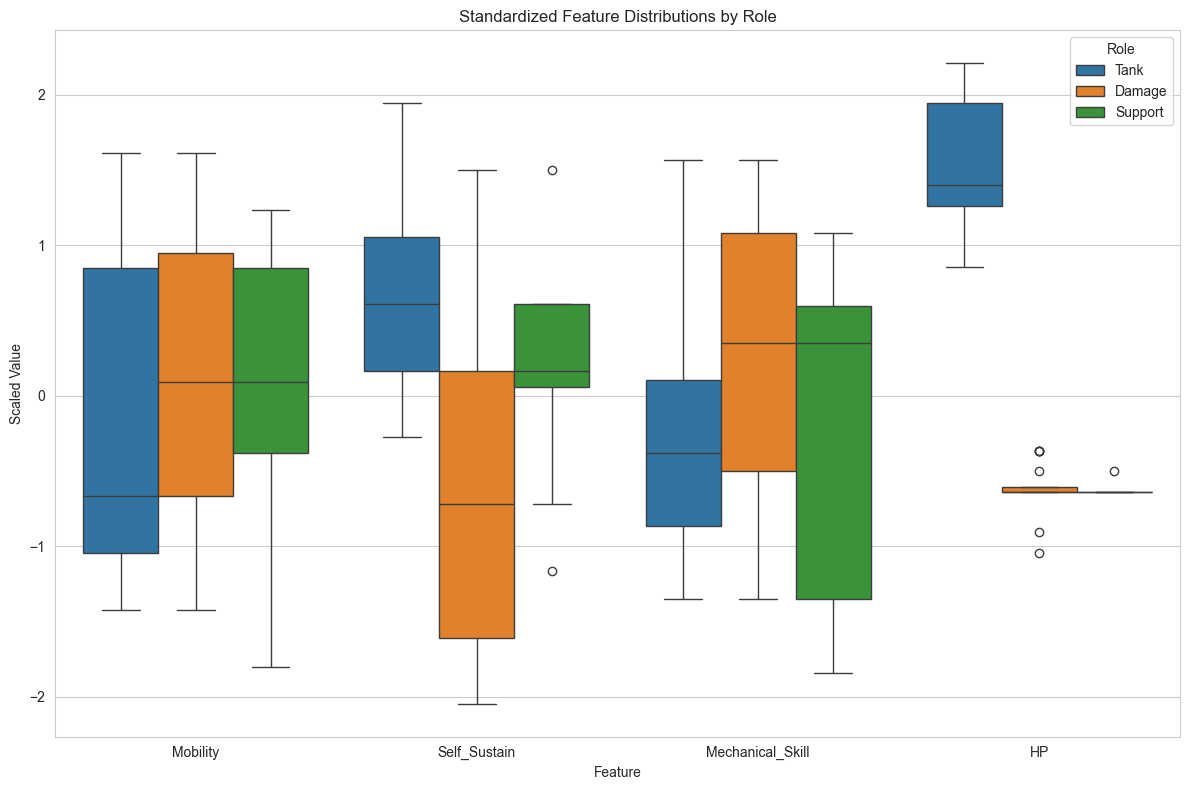

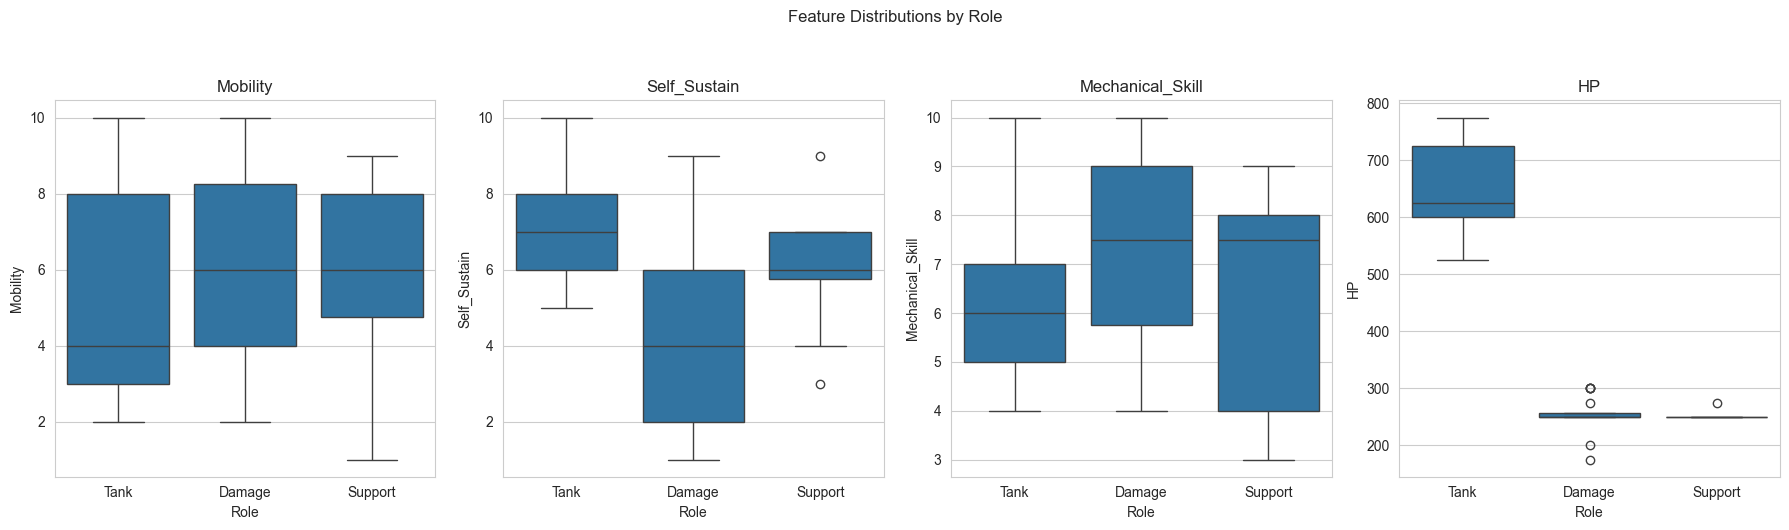

In [5]:

# Feature distributions by role
from sklearn.preprocessing import StandardScaler

# Standardize all numeric features
scaler = StandardScaler()
scaled = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled, columns=features)
scaled_df["Role"] = df["Role"]

melted_scaled = scaled_df.melt(id_vars=["Role"], 
                               value_vars=features, 
                               var_name="Feature", 
                               value_name="Scaled Value")

plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_scaled, x="Feature", y="Scaled Value", hue="Role")
plt.title("Standardized Feature Distributions by Role")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=False)

for i, feat in enumerate(features):
    sns.boxplot(data=df, x="Role", y=feat, ax=axes[i])
    axes[i].set_title(feat)

fig.suptitle("Feature Distributions by Role", y=1.05)
plt.tight_layout()
plt.show()



## 3. Similarity analysis (cosine)

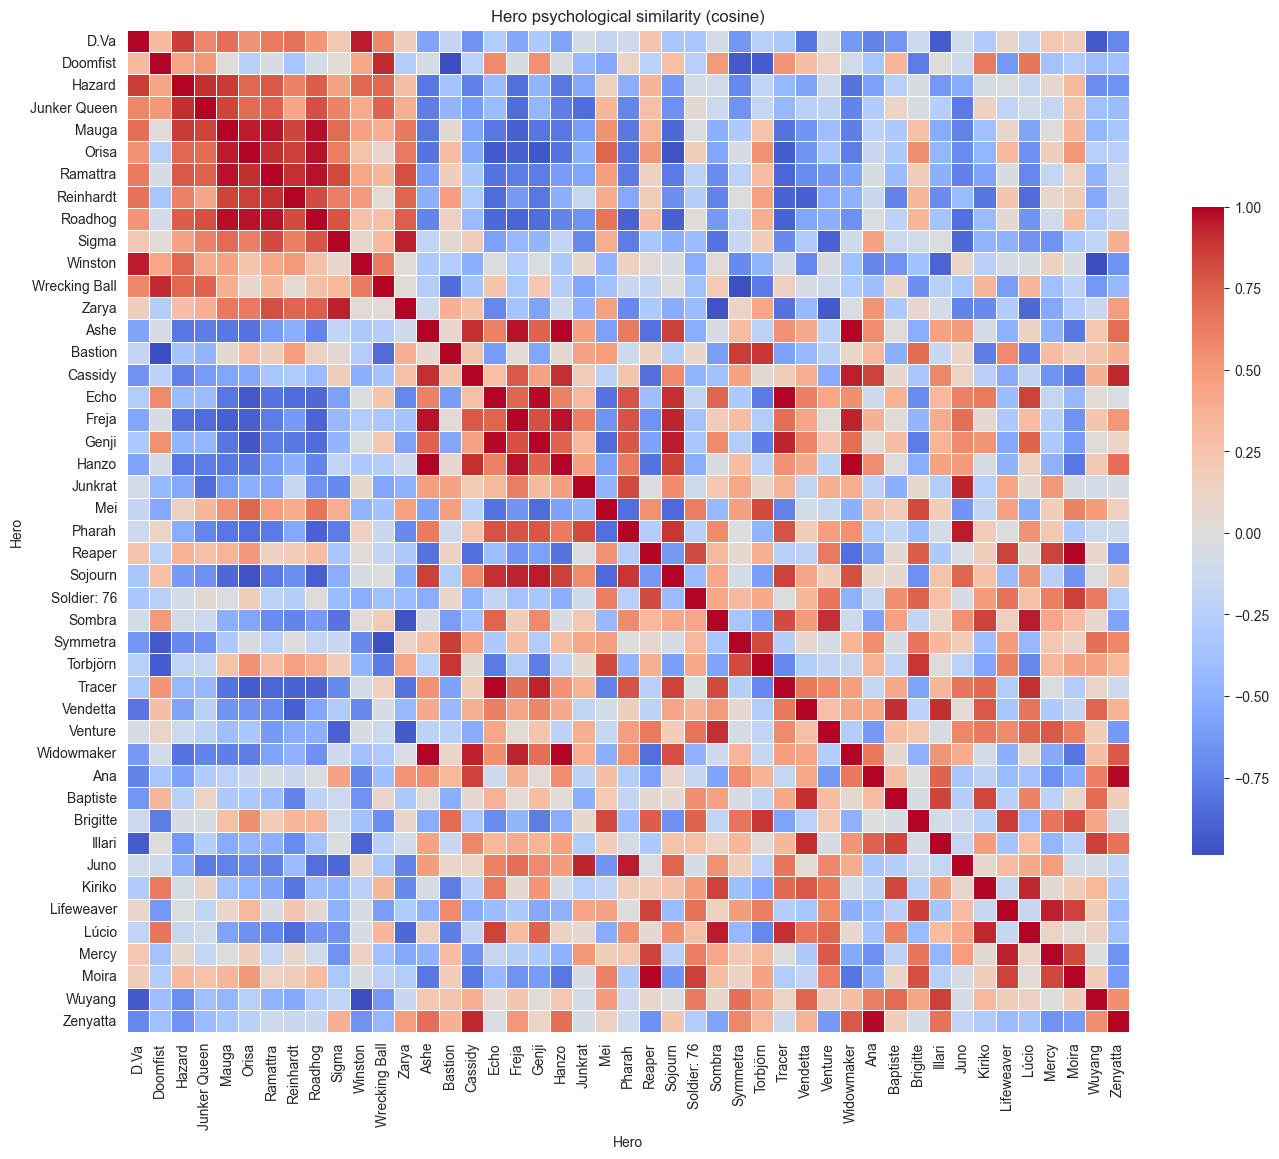

In [6]:

sim_matrix = cosine_similarity(X_scaled)
sim_df = pd.DataFrame(sim_matrix, index=df["Hero"], columns=df["Hero"])

plt.figure(figsize=(14, 12))
sns.heatmap(sim_df, cmap="coolwarm", center=0, square=True,
            linewidths=0.4, cbar_kws={"shrink": 0.6})
plt.title("Hero psychological similarity (cosine)")
plt.tight_layout()
plt.show()


In [7]:

def top_matches_for(hero, n=5):
    if hero not in sim_df.index:
        raise ValueError(f"{hero} not in matrix")
    sims = sim_df.loc[hero].sort_values(ascending=False)
    return sims.iloc[1:n+1]

for hero in ["Hazard", "Mercy", "Genji", "Ana"]:
    print(f"\nTop 5 matches for {hero}:")
    print(top_matches_for(hero))



Top 5 matches for Hazard:
Hero
Junker Queen    0.908298
Mauga           0.869988
D.Va            0.864457
Ramattra        0.770520
Roadhog         0.757801
Name: Hazard, dtype: float64

Top 5 matches for Mercy:
Hero
Lifeweaver    0.939653
Reaper        0.852371
Moira         0.833203
Venture       0.762889
Brigitte      0.652035
Name: Mercy, dtype: float64

Top 5 matches for Genji:
Hero
Echo       0.979250
Sojourn    0.948640
Tracer     0.933548
Freja      0.804519
Pharah     0.778220
Name: Genji, dtype: float64

Top 5 matches for Ana:
Hero
Zenyatta      0.981729
Cassidy       0.848566
Illari        0.735784
Widowmaker    0.647921
Wuyang        0.617555
Name: Ana, dtype: float64


In [8]:

# Build full top‑5 similarity lookup table & export

rows = []
for hero in sim_df.index:
    sims = sim_df.loc[hero].sort_values(ascending=False).iloc[1:6]
    row = {"Hero": hero}
    for i, (match_name, score) in enumerate(sims.items(), start=1):
        row[f"Match_{i}"] = match_name
        row[f"Score_{i}"] = round(score, 4)
    rows.append(row)

full_similarity = pd.DataFrame(rows)
full_similarity.to_csv("overwatch_full_similarity_top5.csv", index=False)

print("Saved top‑5 similarity table to overwatch_full_similarity_top5.csv")
full_similarity.head()


Saved top‑5 similarity table to overwatch_full_similarity_top5.csv


,Hero,Match_1,Score_1,Match_2,Score_2,Match_3,Score_3,Match_4,Score_4,Match_5,Score_5
0,D.Va,Winston,0.9518,Hazard,0.8645,Mauga,0.6819,Reinhardt,0.6666,Ramattra,0.6308
1,Doomfist,Wrecking Ball,0.9197,Lúcio,0.6567,Kiriko,0.6306,Echo,0.5715,Genji,0.5363
2,Hazard,Junker Queen,0.9083,Mauga,0.8700,D.Va,0.8645,Ramattra,0.7705,Roadhog,0.7578
3,Junker Queen,Hazard,0.9083,Mauga,0.8419,Roadhog,0.7998,Ramattra,0.7434,Wrecking Ball,0.7322
4,Mauga,Roadhog,0.9764,Ramattra,0.9645,Orisa,0.9529,Hazard,0.8700,Junker Queen,0.8419


## 4. PCA: building the 2D hero space

In [9]:

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

print("Explained variance by PC1, PC2:", pca.explained_variance_ratio_)
print("Total variance (PC1+PC2):", round(pca.explained_variance_ratio_.sum(), 3))


Explained variance by PC1, PC2: [0.47571788 0.23649675]
Total variance (PC1+PC2): 0.712


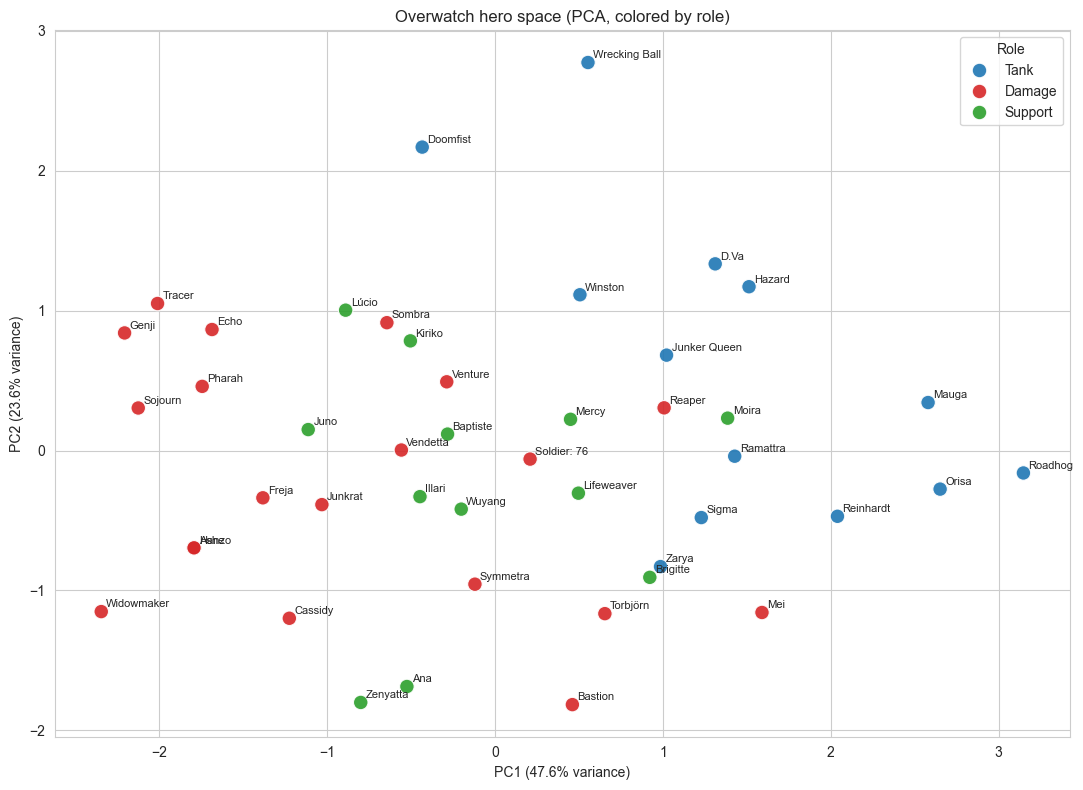

In [10]:

plt.figure(figsize=(11, 8))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="Role",
                palette=role_colors, s=110, alpha=0.9)
for _, row in df.iterrows():
    plt.text(row["PC1"] + 0.03, row["PC2"] + 0.03, row["Hero"], fontsize=8)
plt.title("Overwatch hero space (PCA, colored by role)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.tight_layout()
plt.show()


## 5. K‑Means clustering & choosing k

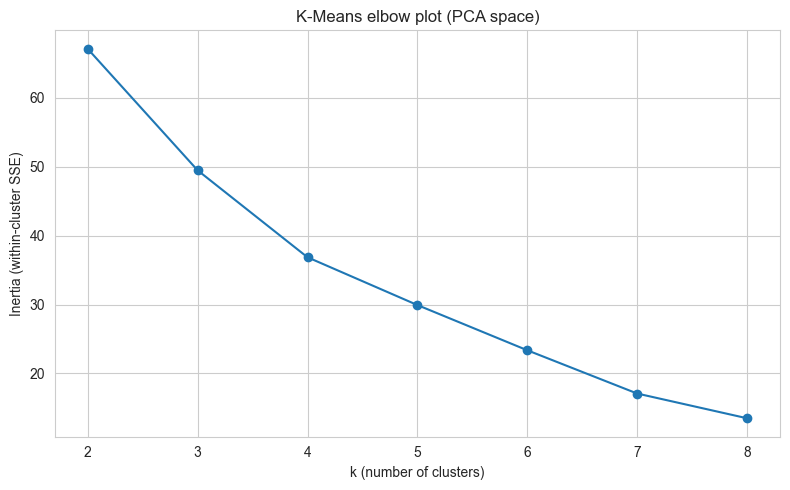

In [11]:

# Elbow plot (inertia vs k)
inertias = []
k_values = range(2, 9)
for k in k_values:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertias, marker="o")
plt.title("K-Means elbow plot (PCA space)")   # fixed hyphen
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.tight_layout()
plt.show()


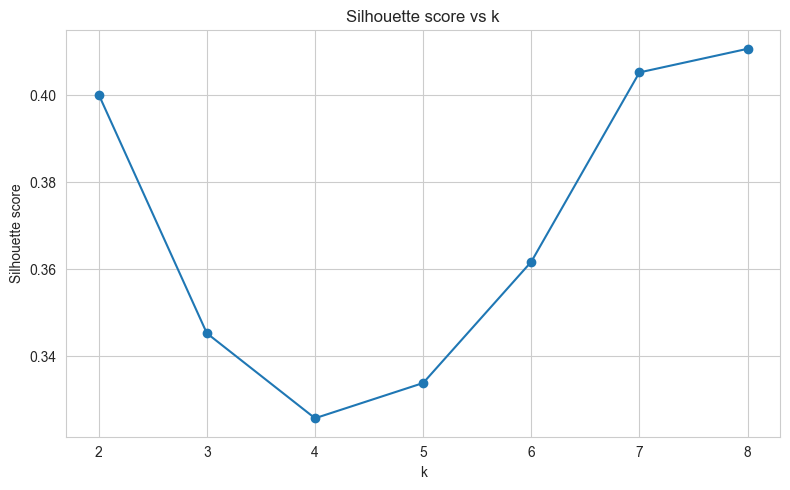

In [12]:

# Silhouette score for several k values
sil_scores = []
k_values = range(2, 9)

for k in k_values:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8,5))
plt.plot(k_values, sil_scores, marker="o")
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()


In [13]:

# Final model with k = 4 archetypes
k = 4
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_pca)

sil_final = silhouette_score(X_pca, df["Cluster"])
print(f"Silhouette score for k=4: {sil_final:.3f}")


Silhouette score for k=4: 0.326


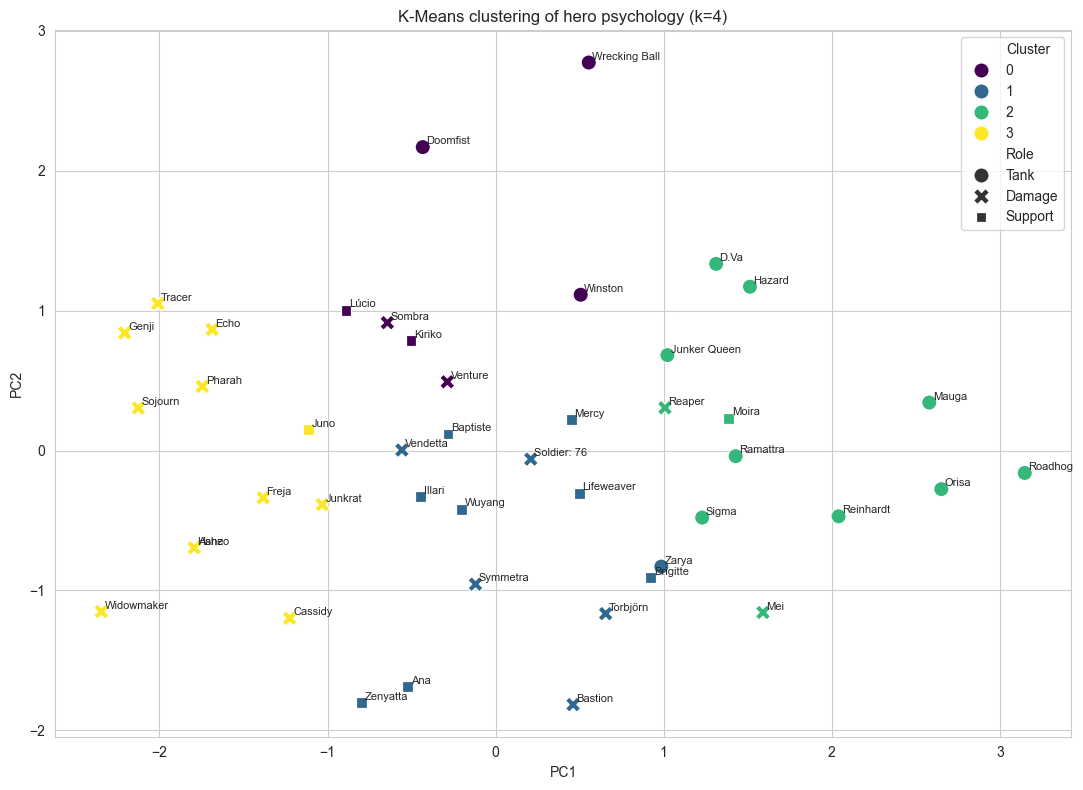

In [14]:

plt.figure(figsize=(11, 8))
sns.scatterplot(
    data=df,
    x="PC1", y="PC2",
    hue="Cluster",
    style="Role",
    palette="viridis",
    s=120
)

for _, row in df.iterrows():
    plt.text(row["PC1"] + 0.02, row["PC2"] + 0.02, row["Hero"], fontsize=8)

plt.title("K-Means clustering of hero psychology (k=4)")   # fixed
plt.tight_layout()
plt.show()


In [15]:

for c in range(k):
    members = df[df["Cluster"] == c]["Hero"].tolist()
    print(f"\n--- Cluster {c} ---")
    print(members)



--- Cluster 0 ---
['Doomfist', 'Winston', 'Wrecking Ball', 'Sombra', 'Venture', 'Kiriko', 'Lúcio']

--- Cluster 1 ---
['Zarya', 'Bastion', 'Soldier: 76', 'Symmetra', 'Torbjörn', 'Vendetta', 'Ana', 'Baptiste', 'Brigitte', 'Illari', 'Lifeweaver', 'Mercy', 'Wuyang', 'Zenyatta']

--- Cluster 2 ---
['D.Va', 'Hazard', 'Junker Queen', 'Mauga', 'Orisa', 'Ramattra', 'Reinhardt', 'Roadhog', 'Sigma', 'Mei', 'Reaper', 'Moira']

--- Cluster 3 ---
['Ashe', 'Cassidy', 'Echo', 'Freja', 'Genji', 'Hanzo', 'Junkrat', 'Pharah', 'Sojourn', 'Tracer', 'Widowmaker', 'Juno']


## 6. Role–cluster relationships

Role     Damage  Support  Tank
Cluster                       
0             2        2     3
1             5        8     1
2             2        1     9
3            11        1     0


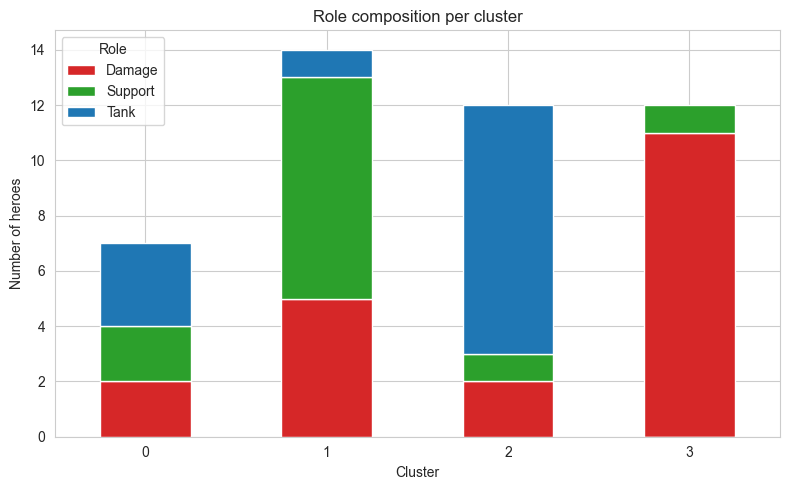

In [16]:

crosstab = pd.crosstab(df["Cluster"], df["Role"])
print(crosstab)

crosstab.plot(kind="bar", stacked=True,
              color=[role_colors[r] for r in crosstab.columns],
              figsize=(8,5))
plt.title("Role composition per cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of heroes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 7. Cluster profiles & archetype naming

         Mobility  Self_Sustain  Mechanical_Skill      HP
Cluster                                                  
0            8.86          6.43              7.86  417.86
1            4.21          5.79              6.29  280.36
2            4.58          8.00              5.17  564.58
3            6.92          2.58              8.33  241.67


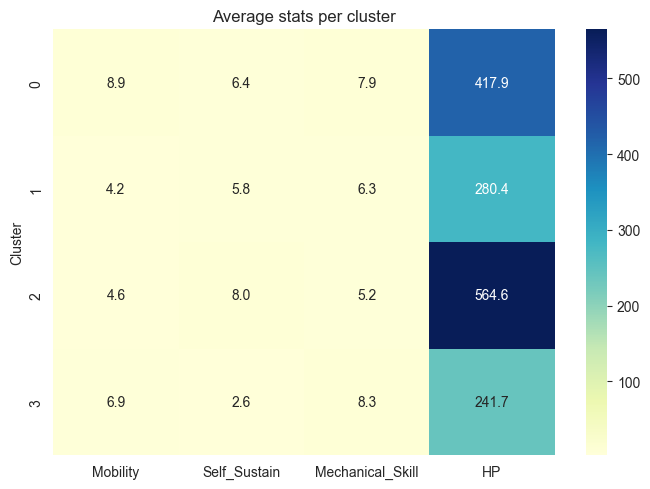

In [17]:

cluster_means = df.groupby("Cluster")[features].mean()
print(cluster_means.round(2))

plt.figure(figsize=(7,5))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average stats per cluster")
plt.tight_layout()
plt.show()


In [18]:

# Map clusters to named archetypes
archetype_names = {
    0: "The Skirmishers",
    1: "The Tacticians",
    2: "The Anchors",
    3: "The Sharpshooters",
}
df["Archetype"] = df["Cluster"].map(archetype_names)

hero_archetypes = df[["Hero", "Role", "Cluster", "Archetype"]].sort_values("Hero")
hero_archetypes.to_csv("overwatch_hero_archetypes.csv", index=False)
hero_archetypes.head(10)


,Hero,Role,Cluster,Archetype
33,Ana,Support,1,The Tacticians
13,Ashe,Damage,3,The Sharpshooters
34,Baptiste,Support,1,The Tacticians
14,Bastion,Damage,1,The Tacticians
35,Brigitte,Support,1,The Tacticians
15,Cassidy,Damage,3,The Sharpshooters
0,D.Va,Tank,2,The Anchors
1,Doomfist,Tank,0,The Skirmishers
16,Echo,Damage,3,The Sharpshooters
17,Freja,Damage,3,The Sharpshooters


## 8. Archetype radar charts (normalized)
These show the *shape* of each archetype across Mobility, Sustain, Mechanical Skill, and HP, all on a common 0–1 scale.

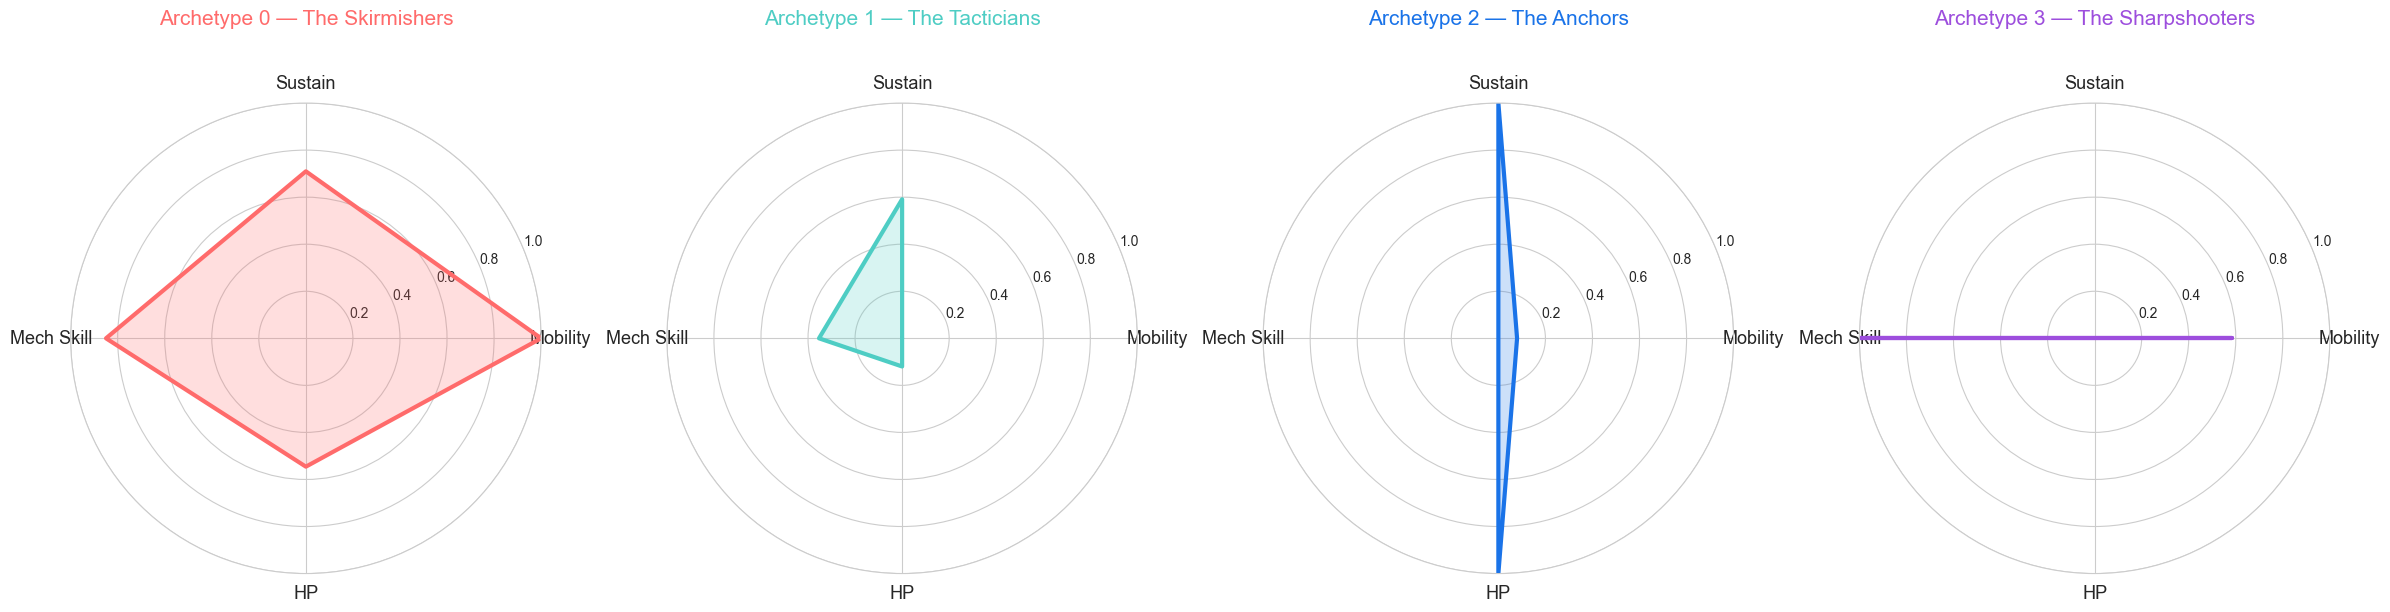

In [19]:

radar_features = ["Mobility", "Self_Sustain", "Mechanical_Skill", "HP"]
radar_data = cluster_means[radar_features].copy()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

N = len(radar_features)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

archetype_colors = {
    0: "#FF6B6B",   # Skirmishers
    1: "#4ECDC4",   # Tacticians
    2: "#1A73E8",   # Anchors
    3: "#9D4EDD",   # Sharpshooters
}

titles = [
    "Archetype 0 — The Skirmishers",
    "Archetype 1 — The Tacticians",
    "Archetype 2 — The Anchors",
    "Archetype 3 — The Sharpshooters",
]

fig, axes = plt.subplots(1, k, subplot_kw=dict(polar=True), figsize=(24, 6))

for i in range(k):
    ax = axes[i]
    vals = radar_norm.iloc[i].values.tolist()
    vals += vals[:1]

    ax.plot(angles, vals, linewidth=3, linestyle="solid", color=archetype_colors[i])
    ax.fill(angles, vals, color=archetype_colors[i], alpha=0.22)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(["Mobility", "Sustain", "Mech Skill", "HP"], fontsize=13)

    ax.set_title(titles[i], size=15, color=archetype_colors[i], y=1.15)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


## 9. Cluster fingerprint radar charts (per‑hero spread)
Gray lines show individual heroes inside each archetype; the colored line shows the mean.

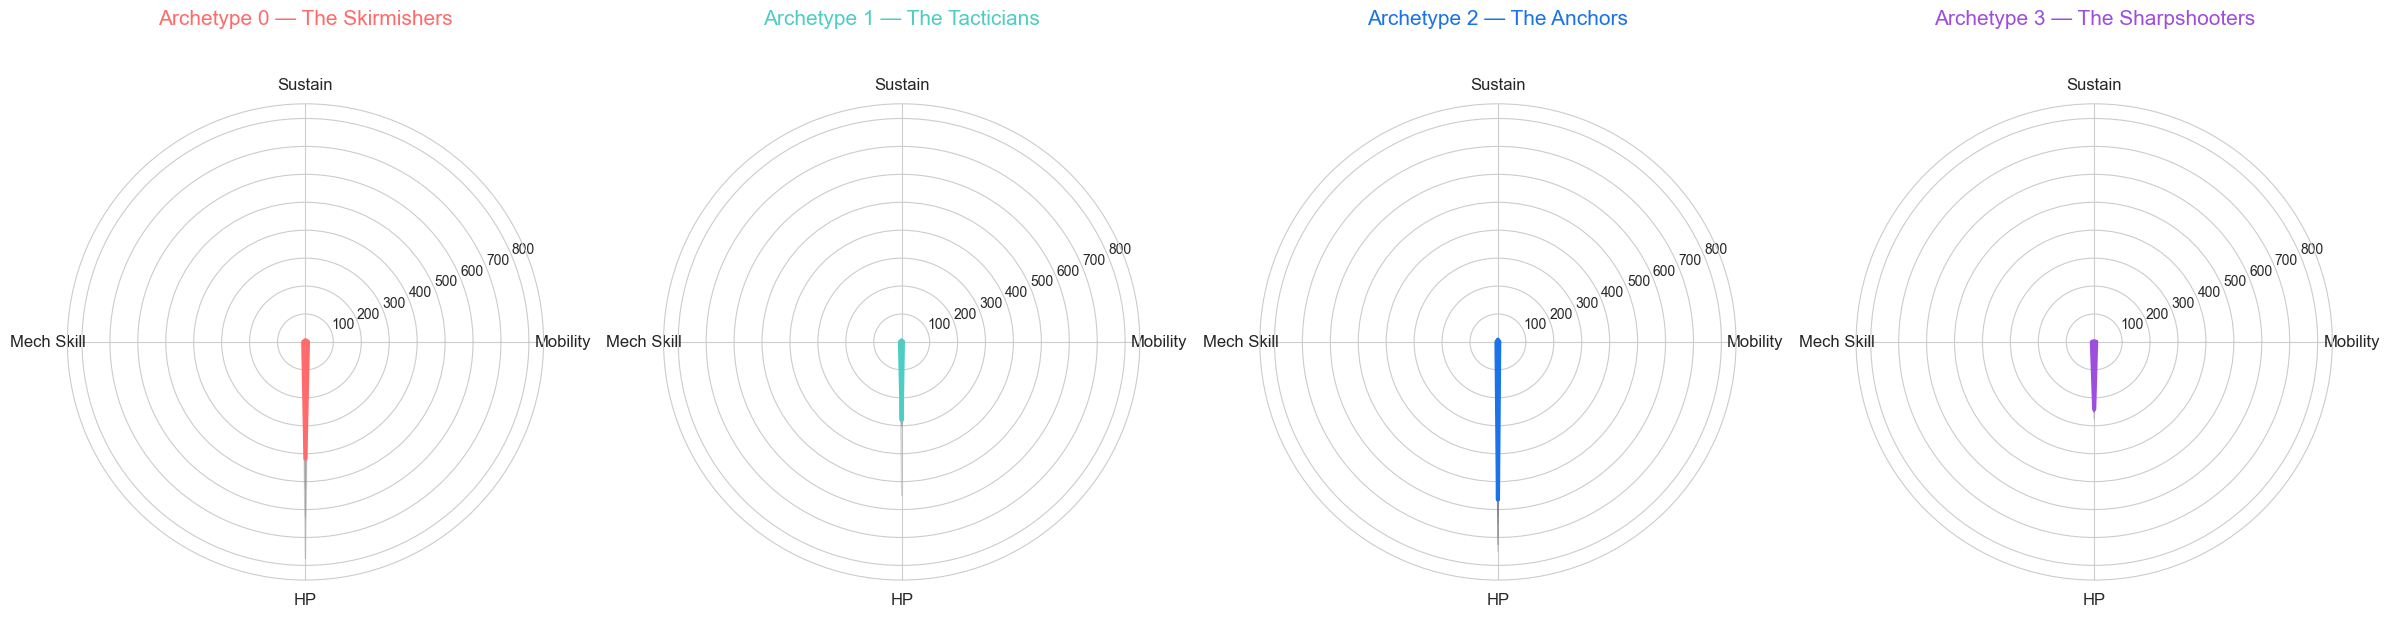

In [20]:

fig, axes = plt.subplots(1, k, subplot_kw=dict(polar=True), figsize=(24, 6))

for i in range(k):
    ax = axes[i]
    subset = df[df["Cluster"] == i][radar_features]

    # per‑hero
    for _, row in subset.iterrows():
        vals = row.values.tolist()
        vals += vals[:1]
        ax.plot(angles, vals, color="gray", linewidth=1, alpha=0.3)

    mean_vals = cluster_means.iloc[i].values.tolist()
    mean_vals += mean_vals[:1]
    ax.plot(angles, mean_vals, color=archetype_colors[i], linewidth=3)
    ax.fill(angles, mean_vals, color=archetype_colors[i], alpha=0.18)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(["Mobility", "Sustain", "Mech Skill", "HP"], fontsize=12)
    ax.set_title(titles[i], color=archetype_colors[i], size=15, y=1.15)
    ax.set_ylim(0, max(df[radar_features].max()) * 1.1)

plt.tight_layout()
plt.show()


# 10. Parallel coordinates plot: seeing archetypes across stats

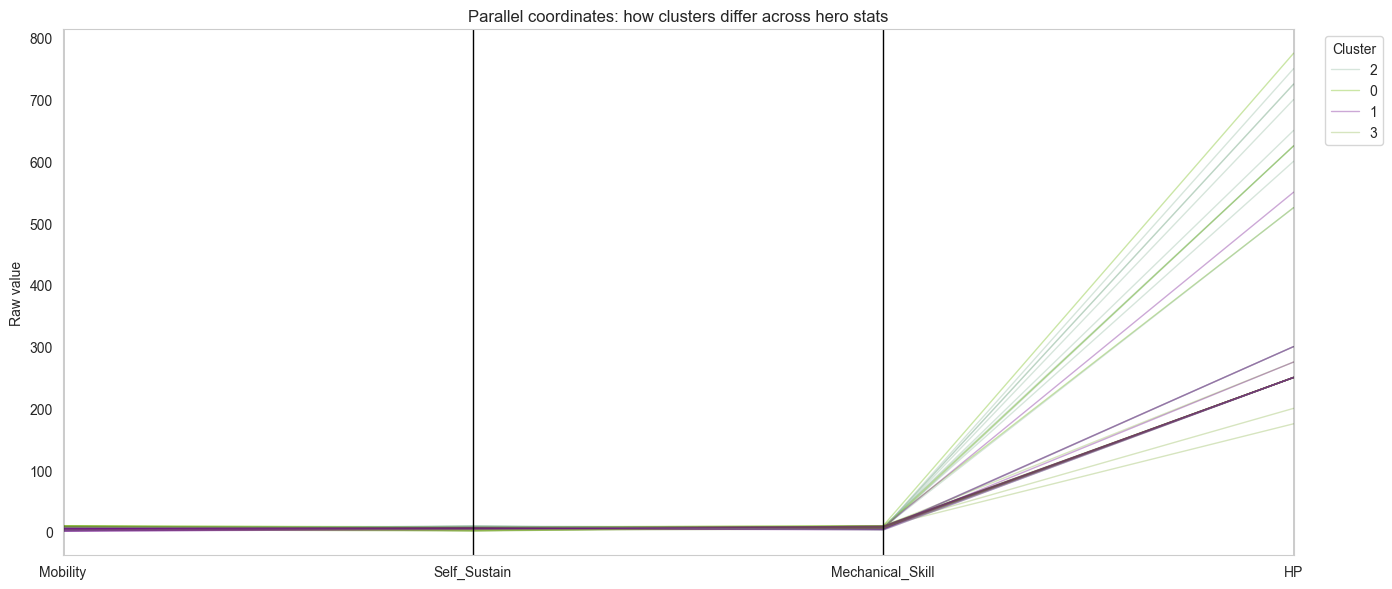

In [21]:
from pandas.plotting import parallel_coordinates

# Build a small frame with cluster label + features
pc_df = df[["Hero", "Cluster"] + features].copy()
pc_df["Cluster"] = pc_df["Cluster"].astype(str)

plt.figure(figsize=(14, 6))
parallel_coordinates(pc_df, "Cluster", cols=features, alpha=0.35, linewidth=1.0)
plt.title("Parallel coordinates: how clusters differ across hero stats")
plt.ylabel("Raw value")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



# 11. Cluster summary table (averages in a nice, readable way)

In [23]:
# 10. Cluster summary table (for narrative & Medium)
summary_table = cluster_means.copy()
summary_table = summary_table.rename(index={
    0: "Archetype 0 — Skirmishers",
    1: "Archetype 1 — Tacticians",
    2: "Archetype 2 — Anchors",
    3: "Archetype 3 — Sharpshooters"
})

display(summary_table.round(1))

,Mobility,Self_Sustain,Mechanical_Skill,HP
Cluster,,,,
Archetype 0 — Skirmishers,8.9,6.4,7.9,417.9
Archetype 1 — Tacticians,4.2,5.8,6.3,280.4
Archetype 2 — Anchors,4.6,8.0,5.2,564.6
Archetype 3 — Sharpshooters,6.9,2.6,8.3,241.7


# 12. Tiny “hero recommender” helper

In [24]:
# 11. Simple helper: recommend heroes from each archetype
archetype_labels = {
    0: "Skirmishers (high mobility, high mechanics, low safety)",
    1: "Tacticians (balanced, positional, cooldown-focused)",
    2: "Anchors (frontline, high sustain, protect the team)",
    3: "Sharpshooters (precision aim, low forgiveness)"
}

def show_archetype_examples():
    """Print a few representative heroes per archetype."""
    for c in sorted(df["Cluster"].unique()):
        heroes = df[df["Cluster"] == c].sort_values("Mechanical_Skill", ascending=False)["Hero"].tolist()
        print(f"\n{archetype_labels[c]}")
        print("  Examples:", ", ".join(heroes[:5]))

show_archetype_examples()



Skirmishers (high mobility, high mechanics, low safety)
  Examples: Doomfist, Wrecking Ball, Lúcio, Kiriko, Sombra

Tacticians (balanced, positional, cooldown-focused)
  Examples: Zenyatta, Ana, Baptiste, Illari, Vendetta

Anchors (frontline, high sustain, protect the team)
  Examples: Sigma, Junker Queen, Ramattra, Hazard, Mauga

Sharpshooters (precision aim, low forgiveness)
  Examples: Widowmaker, Genji, Ashe, Cassidy, Tracer


## Final Summary

• We extended the original *"We Are Who We Lock"* cosine-similarity analysis to the
  full 45-hero Overwatch roster, using a richer feature set:
  **mobility**, **self-sustain**, **mechanical skill**, and **HP**.

• Using **PCA**, we built a 2D “hero psychology space” that shows how heroes naturally
  separate into patterns based on how they approach fights, take information in, and
  act on it.

• Using **K-Means** with silhouette support (optimal k = 4), we discovered four
  psychologically meaningful archetypes:

### **Archetype 0 — The Skirmishers**
Fast, evasive, high-mechanics heroes.
They thrive on constant movement, proactive decision-making, and high APM.

### **Archetype 1 — The Tacticians**
Moderate mobility + moderate sustain.
They win through positioning, timing, cooldown management, and game sense.

### **Archetype 2 — The Anchors**
High-HP, high-sustain heroes.
They stabilize space, protect teammates, and simplify the fight around them.

### **Archetype 3 — The Sharpshooters**
Low-sustain, high-precision heroes.
They rely on accuracy, prediction, and tight mechanical discipline.

• These archetypes line up with how players intuitively describe themselves:
  **creative skirmishers**, **strategic tacticians**, **protective anchors**, and  
  **precise sharpshooters** — supporting the claim that *we really are who we lock.*

**Saved Artifacts**
- `overwatch_full_similarity_top5.csv` — top-5 similarity matches for every hero.  
- `overwatch_hero_archetypes.csv` — final hero → role → archetype mapping.

---

## How to Use This as a Player

- If you enjoy **fast, risky outplays**, try heroes from the **Skirmishers**.
- If you like **protecting your team and controlling space**, explore the **Anchors**.
- If you think in terms of **angles, utility, and smart positioning**, check **Tacticians**.
- If you love **aim duels and precision**, start with the **Sharpshooters**.

Your current hero pool probably clusters in one or two archetypes —  
and that cluster reflects *your natural information-processing style*.

Understanding your archetype helps you:
1. Find new heroes you’ll naturally enjoy,  
2. Understand why some heroes feel stressful or unnatural,  
3. Improve faster by playing in a way that matches how your brain prefers to play.

This analysis shows that hero choice isn’t random —  
**it’s a reflection of how you interpret the game, solve problems, and make decisions.**
